In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
from vis_settings import lag_colors as colors

In [3]:
fair_temperatures_low = xr.open_dataset("../data/outputs/temperature_low_emissions.nc").to_array().isel(variable=0)
fair_temperatures_med = xr.open_dataset("../data/outputs/temperature_medium_emissions.nc").to_array().isel(variable=0)
fair_temperatures_high = xr.open_dataset("../data/outputs/temperature_high_emissions.nc").to_array().isel(variable=0)
fair_temperatures=fair_temperatures_low

In [4]:
ds_timebounds = pd.read_csv("../data/outputs/timebounds.csv")
timebounds=ds_timebounds['0'].values

# Make figures

In [5]:
baseline_scenario = 'low'

scenarios = [
    "baseline",
  "instant-removal-offsetting",
 "physical-delay-offsetting",
 "accelerated-emissions-offsetting",
    "upfront-embodied-offsetting",
]

fancy_titles = {
    'baseline': 'Baseline',
    "instant-removal-offsetting":"Instant Removal",
    "physical-delay-offsetting":"Physical / Counterfactual Delay",
    "accelerated-emissions-offsetting":"Accelerated Emissions",
    "upfront-embodied-offsetting":"Upfront Emissions",
}

linestyles = {
    'baseline': '-',
    "instant-removal-offsetting":"--",
    "physical-delay-offsetting":"-",
    "accelerated-emissions-offsetting":"-",
    "upfront-embodied-offsetting":"-",
}

In [6]:
weights_51yr = np.ones(52)
weights_51yr[0] = 0.5
weights_51yr[-1] = 0.5

### Difference from baseline

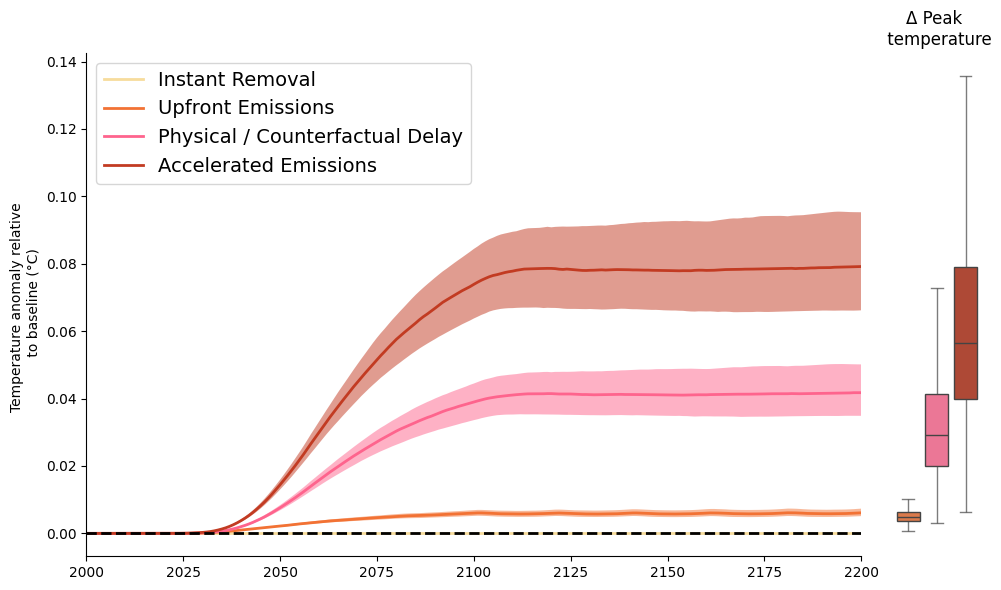

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6), sharey=True,
                        gridspec_kw={'width_ratios': [9, 1]})

scenarios_to_plot = ['instant-removal-offsetting',
                     'upfront-embodied-offsetting',
 'physical-delay-offsetting',
 'accelerated-emissions-offsetting',
 ]

pp = (25,75)

ax=axes[0]

for i, scenario in enumerate(scenarios_to_plot):
    ax.fill_between(
        timebounds,
        np.percentile(
            fair_temperatures.loc[dict(scenario=scenario, layer=0)]
            - fair_temperatures.loc[dict(scenario="baseline", layer=0)],
            pp[0],
            axis=1,
        ),
        np.percentile(
            fair_temperatures.loc[dict(scenario=scenario, layer=0)]
            - fair_temperatures.loc[dict(scenario="baseline", layer=0)],
            pp[1],
            axis=1,
        ),
        color=colors[scenario],
        alpha=0.5,
        lw=0
    )

    ax.plot(
        timebounds,
        np.median(
            fair_temperatures.loc[dict(scenario=scenario, layer=0)]
            - fair_temperatures.loc[dict(scenario="baseline", layer=0)],
            axis=1,
        ),
        color=colors[scenarios_to_plot[i]],label=fancy_titles[scenarios_to_plot[i]],
        lw=2
    )
ax.set_xlim(2000, 2200)
ax.legend(loc='upper left', fontsize=14)
ax.axhline(y=0, color="k", ls="--", lw=2, label='Baseline')
ax.set_ylabel('Temperature anomaly relative \n to baseline (°C)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


#### Peak temperatures
ax=axes[1]
colors_to_plot = [colors[scenario] for scenario in scenarios_to_plot[1:]]

peak_temperatures = (fair_temperatures[:451].sel(layer=0).rolling(timebounds=20).mean().max(dim='timebounds')
                     - (np.average(
                fair_temperatures.loc[
                    dict(scenario=scenario, timebounds=np.arange(1850, 1902), layer=0)
                ]))).transpose().to_pandas()


for i,scenario in enumerate(scenarios_to_plot[1:]):
    peak_temp_diff = (peak_temperatures[scenario]-
                      peak_temperatures["baseline"])
    if i==0:
        peak_temp_diffs=peak_temp_diff.to_frame(name=fancy_titles[scenario])
    else:
        peak_temp_diffs[fancy_titles[scenario]]=peak_temp_diff

sns.boxplot(
    data=peak_temp_diffs,
    palette=colors_to_plot,
    ax=ax,
    boxprops=dict(alpha=1), 
    whiskerprops=dict(alpha=0.7),
    capprops=dict(alpha=0.7),
    medianprops=dict(alpha=1),
    showfliers=False
)
ax.set_xticklabels([])
ax.set_xticks([])
ax.tick_params(left=False, labelleft=False)
ax.set_title('Δ Peak \n temperature')
ax.set_xlim(-0.5, 2.5)
for spine in ax.spines.values():
    spine.set_visible(False)
fig.tight_layout()
plt.savefig('../figures/Peak_temperature_change.pdf')
plt.savefig('../figures/Peak_temperature_change.png', dpi=200)

# Exploratory

### Scenario trajectories

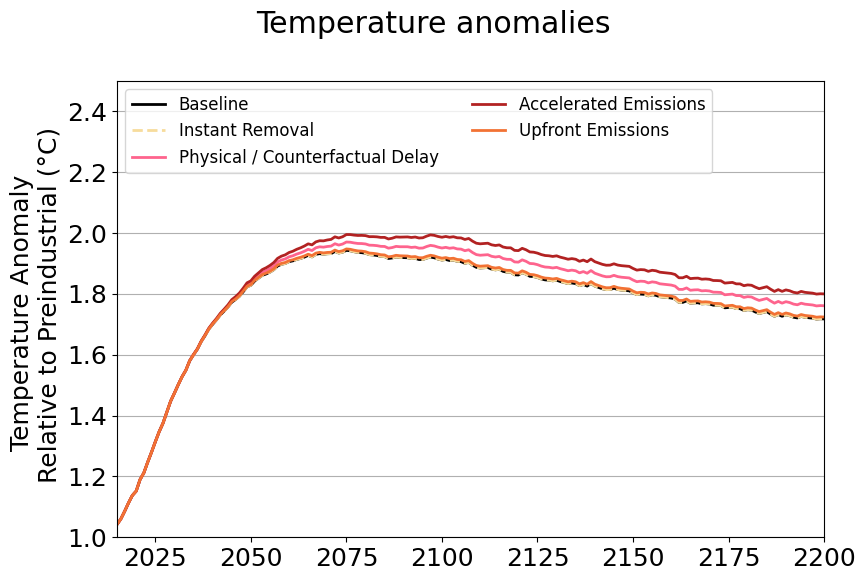

In [8]:
ncols=3
plt.rcParams['font.size'] = 18
fig = plt.figure(figsize=(9, 6))

for i, scenario in enumerate(scenarios):
    if scenario=='low':
        timebounds_start=0
    else:
        timebounds_start=250
    linewidth=2
    alpha=1
    plt.plot(
        timebounds[timebounds_start:],
        np.mean(
            fair_temperatures.loc[dict(scenario=scenario, layer=0)]
            - np.average(
                fair_temperatures.loc[
                    dict(scenario=scenario, timebounds=np.arange(1850, 1902), layer=0)
                ],
                #weights=weights_51yr,
                axis=0
            ),
            axis=1,
        )[timebounds_start:],
        color=colors[scenario],
        linestyle=linestyles[scenario],
        label=fancy_titles[scenario],
        linewidth=linewidth,
        alpha=alpha
    )
plt.xlim([2015, 2200])
plt.ylim([1.0, 2.5])
plt.axhline(0, color="k", ls=":", lw=0.5)
plt.legend(fontsize=12, loc='upper left', ncols=2)
plt.grid(axis='y')
plt.ylabel('Temperature Anomaly \n Relative to Preindustrial (°C)')

plt.suptitle("Temperature anomalies")
fig.tight_layout()
plt.savefig('../figures/Temperature_anomalies_v2.pdf')

# Peak temperatures

In [8]:
peak_temperatures = (fair_temperatures[:451].sel(layer=0).rolling(timebounds=20).mean().max(dim='timebounds')
                     - (np.average(
                fair_temperatures.loc[
                    dict(scenario=scenario, timebounds=np.arange(1850, 1902), layer=0)
                ]))).transpose().to_pandas()
peak_temperatures.to_csv('../data/outputs/peak_temperatures.csv')

Text(0.5, 0, 'Peak Temperature')

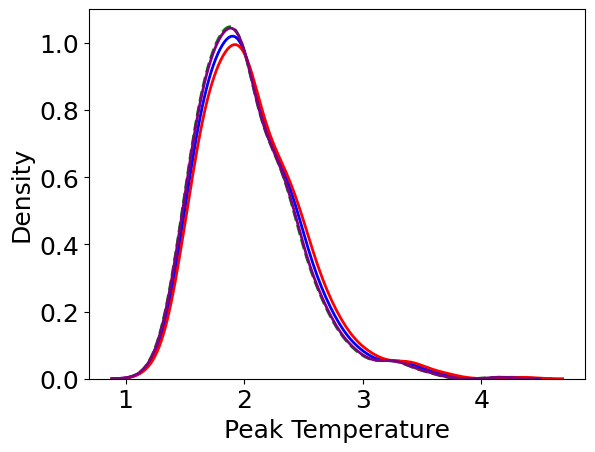

In [9]:
for i,scenario in enumerate(scenarios_to_plot):
    sns.kdeplot(peak_temperatures[scenario], 
                bw_adjust=1,
                color=colors[scenario],
                label=scenario, 
                lw=2,linestyle=linestyles[scenario])
#plt.xlim([0.75,4])
plt.xlabel('Peak Temperature')

In [37]:
peak_temp_diff = (peak_temperatures["upfront-embodied-offsetting"]-
                      peak_temperatures["baseline"])

In [39]:
np.nanstd(peak_temp_diff)

np.float64(0.001957604470116435)

In [27]:
peak_temperatures

scenario,baseline,instant-removal-offsetting,physical-delay-offsetting,accelerated-emissions-offsetting,upfront-embodied-offsetting
config,,,,,
1234,1.547198,1.547198,1.562045,1.575330,1.549958
2451,1.743544,1.743544,1.767504,1.789635,1.747671
5859,2.276251,2.276251,2.309867,2.340006,2.282271
5883,1.459391,1.459391,1.480029,1.498670,1.462598
14573,1.992852,1.992852,2.016042,2.047936,1.997113
...,...,...,...,...,...
1590667,2.068378,2.068378,2.099358,2.127164,2.073522
1590821,1.901101,1.901101,1.916858,1.930978,1.904379
1592589,1.426501,1.426501,1.449194,1.470909,1.430338


In [10]:
for i,scenario in enumerate(scenarios_to_plot):
    peak_temp_diff = (peak_temperatures[scenario]-
                      peak_temperatures[baseline_scenario])
    sns.kdeplot(peak_temp_diff, 
                bw_adjust=1,
                color=colors[scenario],
                label=fancy_titles[scenario], 
                lw=2,linestyle='-')
plt.xlabel('Change in Peak Temperature (°C relative to baseline)', fontsize=12)
plt.legend(fontsize=14)

KeyError: 'low'

In [ ]:
scenarios_to_plot=[
 'physical-delay-offsetting',
 'accelerated-emissions-offsetting',
 'upfront-embodied-offsetting']
colors_to_plot = [colors[scenario] for scenario in scenarios_to_plot]

for i,scenario in enumerate(scenarios_to_plot):
    peak_temp_diff = (peak_temperatures[scenario]-
                      peak_temperatures[baseline_scenario])
    if i==0:
        peak_temp_diffs=peak_temp_diff.to_frame(name=fancy_titles[scenario])
    else:
        peak_temp_diffs[fancy_titles[scenario]]=peak_temp_diff

sns.violinplot(peak_temp_diffs, palette=colors_to_plot, alpha=0.5, cut=0)
plt.axhline(y=0, linestyle='--',color='k')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

(array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 [Text(0, 1.0, '1.0'),
  Text(0, 1.5, '1.5'),
  Text(0, 2.0, '2.0'),
  Text(0, 2.5, '2.5'),
  Text(0, 3.0, '3.0'),
  Text(0, 3.5, '3.5'),
  Text(0, 4.0, '4.0'),
  Text(0, 4.5, '4.5'),
  Text(0, 5.0, '5.0')])

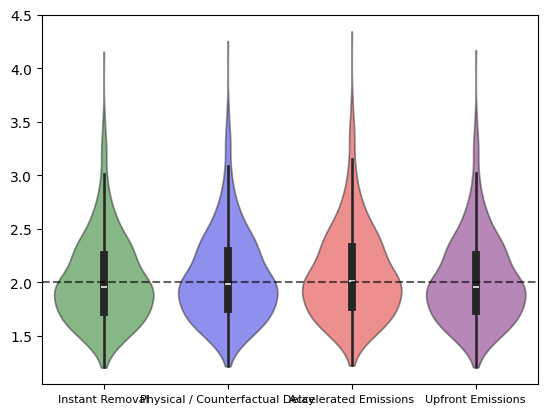

In [11]:
scenarios_to_plot=["instant-removal-offsetting",
 'physical-delay-offsetting',
 'accelerated-emissions-offsetting',
 'upfront-embodied-offsetting']
colors_to_plot = [colors[scenario] for scenario in scenarios_to_plot]

for i,scenario in enumerate(scenarios_to_plot):
    peak_temps = (peak_temperatures[scenario])
    
    if i==0:
        peak_temp_all=peak_temps.to_frame(name=fancy_titles[scenario])
    else:
        peak_temp_all[fancy_titles[scenario]]=peak_temps

sns.violinplot(peak_temp_all, palette=colors_to_plot, alpha=0.5, cut=0)
plt.axhline(y=2, linestyle='--',color='k', alpha=0.6)
plt.xticks(fontsize=8)
plt.yticks(fontsize=10)

In [41]:
# Fraction of ensemble members with peak temperature below 2 degrees C
(peak_temp_all>2).sum()/len(peak_temp_all)

# If we take each ensemble member as equal likelihood, then this mean that
# relying on CDR with accelerated emissions increases probability of exceeding 2 degrees by ~6%

Instant Removal                    0.451843
Physical / Counterfactual Delay    0.478002
Accelerated Emissions              0.513674
Upfront Emissions                  0.456599
dtype: float64

In [45]:
(0.456599-0.451843)*100

0.47559999999999825

# Comparing SSPs

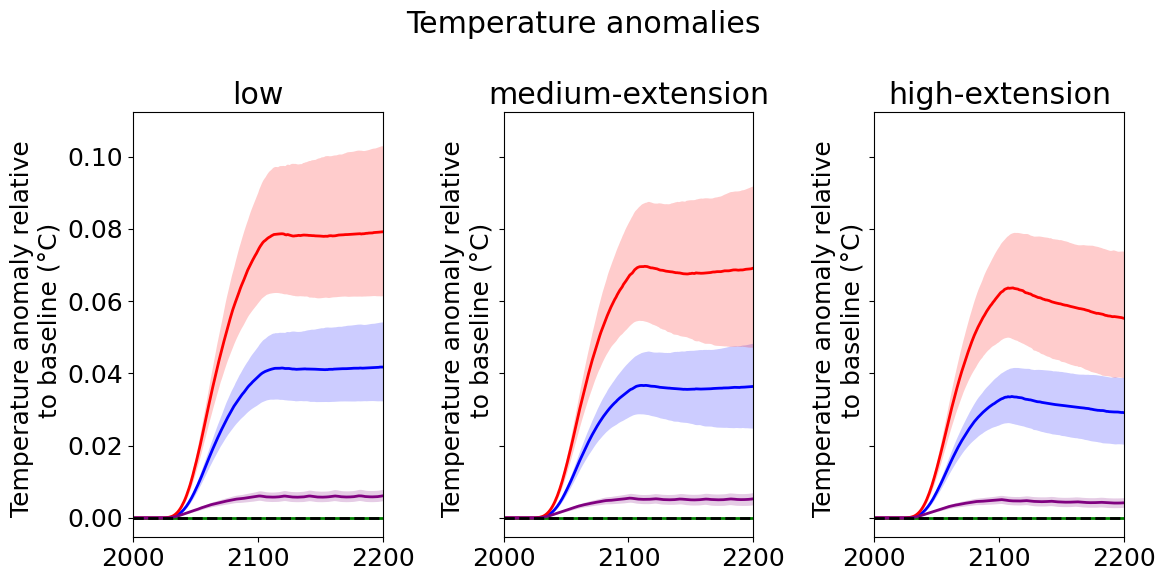

In [12]:
fig, axes= plt.subplots(nrows=1, ncols=3, figsize=(12, 6), sharey=True)

simulation_sets = [fair_temperatures_low,
                   fair_temperatures_med,
                   fair_temperatures_high]

baseline_scenarios = ['low','medium-extension','high-extension']

scenarios_to_plot = ['instant-removal-offsetting',
 'physical-delay-offsetting',
 'accelerated-emissions-offsetting',
 'upfront-embodied-offsetting']

pp = (16,84)

for j, fair_temperatures in enumerate(simulation_sets):
    ax=axes[j]
    baseline_scenario=baseline_scenarios[j]
    for i, scenario in enumerate(scenarios_to_plot):
        ax.fill_between(
            timebounds,
            np.percentile(
                fair_temperatures.loc[dict(scenario=scenario, layer=0)]
                - fair_temperatures.loc[dict(scenario=baseline_scenario, layer=0)],
                pp[0],
                axis=1,
            ),
            np.percentile(
                fair_temperatures.loc[dict(scenario=scenario, layer=0)]
                - fair_temperatures.loc[dict(scenario=baseline_scenario, layer=0)],
                pp[1],
                axis=1,
            ),
            color=colors[scenario],
            alpha=0.2,
            lw=0
        )
    
        ax.plot(
            timebounds,
            np.median(
                fair_temperatures.loc[dict(scenario=scenario, layer=0)]
                - fair_temperatures.loc[dict(scenario=baseline_scenario, layer=0)],
                axis=1,
            ),
            color=colors[scenarios_to_plot[i]],label=fancy_titles[scenarios_to_plot[i]],
            lw=2
        )
    ax.set_xlim(2000, 2200)
    #ax.legend()
    ax.set_title(baseline_scenario)
    ax.axhline(y=0, color="k", ls="--", lw=2, label='Baseline')
    ax.set_ylabel('Temperature anomaly relative \n to baseline (°C)')
plt.suptitle("Temperature anomalies")
fig.tight_layout()


/tmp/ipykernel_14350/4169448936.py:27: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(peak_temp_diff,
/tmp/ipykernel_14350/4169448936.py:27: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(peak_temp_diff,
/tmp/ipykernel_14350/4169448936.py:27: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(peak_temp_diff,


Text(0.5, 59.7222222222222, 'Change in Peak Temperature (relative to baseline')

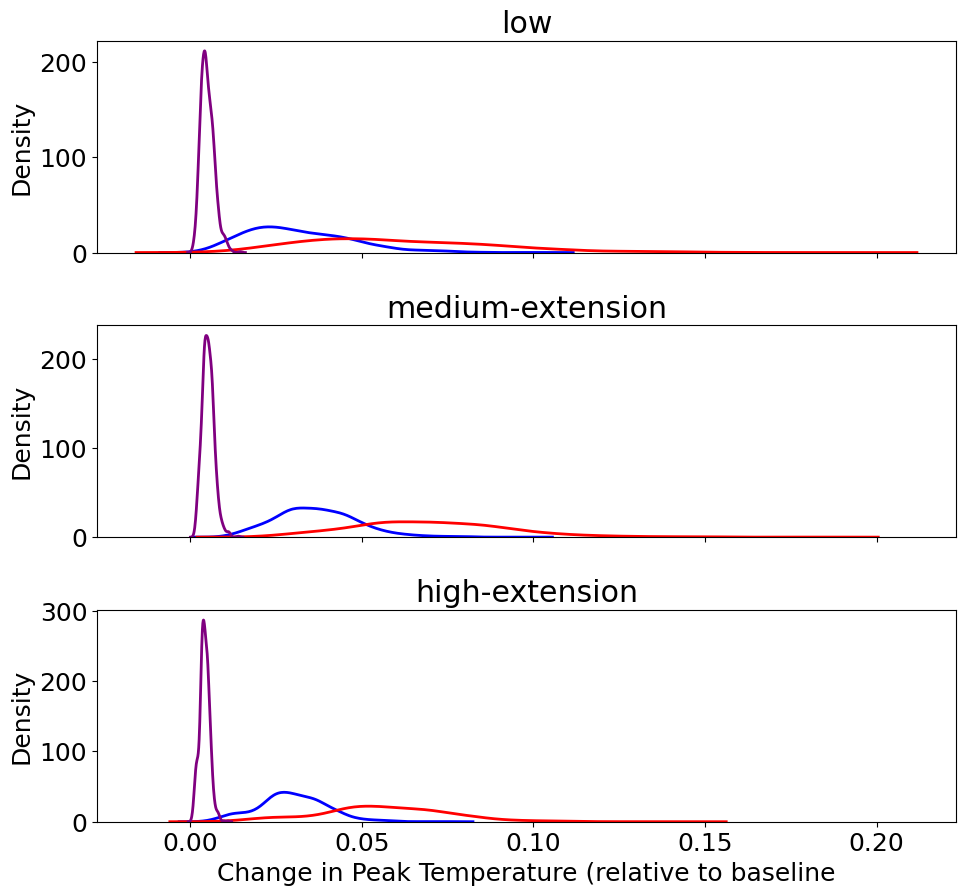

In [20]:
fig, axes= plt.subplots(nrows=3, ncols=1, figsize=(10, 9), sharex=True)

simulation_sets = [fair_temperatures_low,
                   fair_temperatures_med,
                   fair_temperatures_high]

baseline_scenarios = ['low','medium-extension','high-extension']

scenarios_to_plot = ['instant-removal-offsetting',
 'physical-delay-offsetting',
 'accelerated-emissions-offsetting',
 'upfront-embodied-offsetting']

pp = (16,84)

for j, fair_temperatures in enumerate(simulation_sets):
    ax=axes[j]
    baseline_scenario=baseline_scenarios[j]
    peak_temperatures = (fair_temperatures[:451].sel(layer=0).rolling(timebounds=20).mean().max(dim='timebounds')
                     - (np.average(
                fair_temperatures.loc[
                    dict(scenario=scenario, timebounds=np.arange(1850, 1902), layer=0)
                ]))).transpose().to_pandas()
    for i,scenario in enumerate(scenarios_to_plot):
        peak_temp_diff = (peak_temperatures[scenario]-
                          peak_temperatures[baseline_scenario])
        sns.kdeplot(peak_temp_diff, 
                    bw_adjust=1,
                    color=colors[scenario],
                    label=scenario, 
                    lw=2,linestyle='-',ax=ax)
    ax.set_title(baseline_scenario)
    ax.set_label('Change in Peak Temperature (relative to baseline')
plt.tight_layout()
ax.set_xlabel('Change in Peak Temperature (relative to baseline')

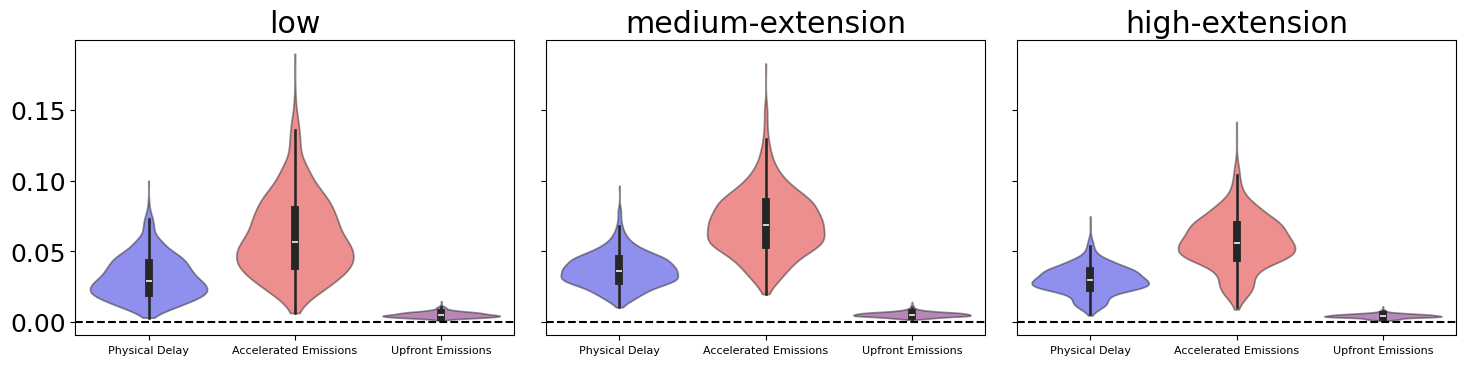

In [24]:
fig, axes= plt.subplots(nrows=1, ncols=3, figsize=(15, 4), sharey=True)

simulation_sets = [fair_temperatures_low,
                   fair_temperatures_med,
                   fair_temperatures_high]

baseline_scenarios = ['low','medium-extension','high-extension']

scenarios_to_plot=[
 'physical-delay-offsetting',
 'accelerated-emissions-offsetting',
 'upfront-embodied-offsetting']
colors_to_plot = [colors[scenario] for scenario in scenarios_to_plot]

for j, fair_temperatures in enumerate(simulation_sets):
    ax=axes[j]
    baseline_scenario=baseline_scenarios[j]
    peak_temperatures = (fair_temperatures[:451].sel(layer=0).rolling(timebounds=20).mean().max(dim='timebounds')
                     - (np.average(
                fair_temperatures.loc[
                    dict(scenario=scenario, timebounds=np.arange(1850, 1902), layer=0)
                ]))).transpose().to_pandas()
    
    for i,scenario in enumerate(scenarios_to_plot):
        peak_temp_diff = (peak_temperatures[scenario]-
                          peak_temperatures[baseline_scenario])
        if i==0:
            peak_temp_diffs=peak_temp_diff.to_frame(name=fancy_titles[scenario])
        else:
            peak_temp_diffs[fancy_titles[scenario]]=peak_temp_diff
    
    sns.violinplot(peak_temp_diffs, palette=colors_to_plot, alpha=0.5, cut=0, ax=ax)
    ax.axhline(y=0, linestyle='--',color='k')
    #ax.xticks(fontsize=10)
    #ax.yticks(fontsize=10)
    ax.tick_params(axis='x', labelsize=8)
    ax.set_title(baseline_scenario)
    ax.set_label('Change in Peak Temperature (relative to baseline')
plt.tight_layout()

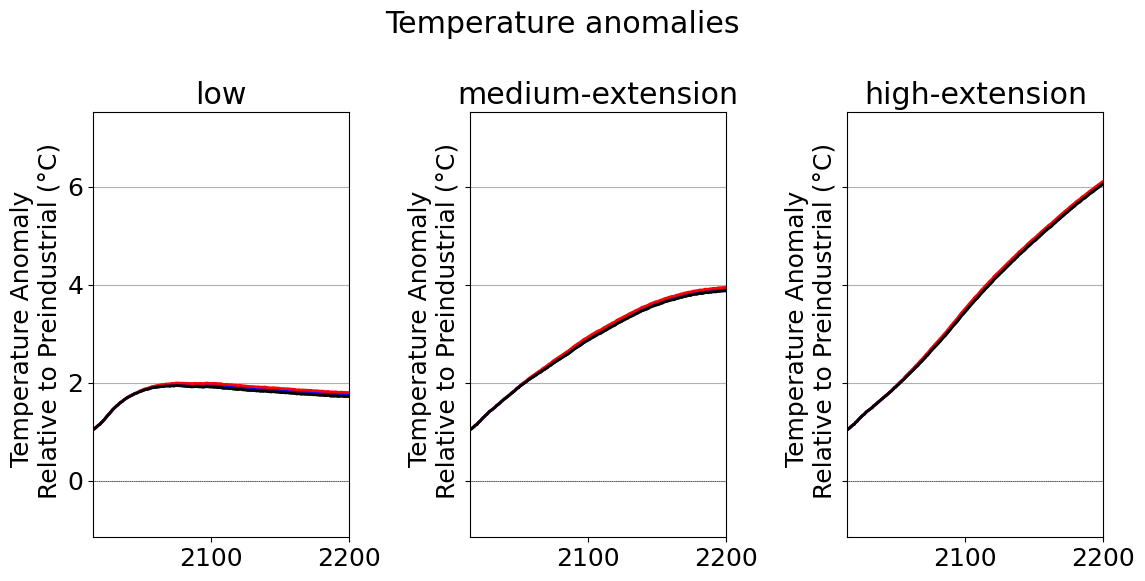

In [14]:
fig, axes= plt.subplots(nrows=1, ncols=3, figsize=(12, 6), sharey=True)

simulation_sets = [fair_temperatures_low,
                   fair_temperatures_med,
                   fair_temperatures_high]

baseline_scenarios = ['low','medium-extension','high-extension']

scenarios_to_plot = ['instant-removal-offsetting',
 'physical-delay-offsetting',
 'accelerated-emissions-offsetting',
 'upfront-embodied-offsetting']

pp = (16,84)

for j, fair_temperatures in enumerate(simulation_sets):
    ax=axes[j]
    baseline_scenario=baseline_scenarios[j]
    scenarios=scenarios_to_plot+[baseline_scenario]
    for i, scenario in enumerate(scenarios):
        if scenario==baseline_scenario:
            timebounds_start=0
        else:
            timebounds_start=250
        linewidth=2
        alpha=1
        ax.plot(
            timebounds[timebounds_start:],
            np.mean(
                fair_temperatures.loc[dict(scenario=scenario, layer=0)]
                - np.average(
                    fair_temperatures.loc[
                        dict(scenario=scenario, timebounds=np.arange(1850, 1902), layer=0)
                    ],
                    #weights=weights_51yr,
                    axis=0
                ),
                axis=1,
            )[timebounds_start:],
            color=colors[scenario],
            linestyle=linestyles[scenario],
            label=fancy_titles[scenario],
            linewidth=linewidth,
            alpha=alpha
        )
    ax.set_xlim([2015, 2200])
    ax.axhline(0, color="k", ls=":", lw=0.5)
    #ax.legend(fontsize=12, loc='upper left', ncols=2)
    ax.grid(axis='y')
    ax.set_title(baseline_scenario)
    ax.set_ylabel('Temperature Anomaly \n Relative to Preindustrial (°C)')

plt.suptitle("Temperature anomalies")
fig.tight_layout()